In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed

In [ ]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
btc_stocks = pd.read_csv('bitcoinStocks.csv')
eth_stocks = pd.read_csv('ethStocks.csv')
ada_stocks = pd.read_csv('adaStocks.csv')

In [ ]:
btc_stocks.head()

,date,open,high,low,close,volume,go_up
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,False
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,False
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,False
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,True
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,False


In [ ]:
btc_stocks_close = btc_stocks.close
btc_stocks_close = btc_stocks_close.to_frame()
btc_stocks_close.head()

,close
0,457.334015
1,424.440002
2,394.795990
3,408.903992
4,398.821014


In [ ]:
eth_stocks_close = eth_stocks.close
eth_stocks_close = eth_stocks_close.to_frame()
eth_stocks_close.head()

,close
0,2.772120
1,0.753325
2,0.701897
3,0.708448
4,1.067860


In [ ]:
ada_stocks_close = ada_stocks.close
ada_stocks_close = ada_stocks_close.to_frame()
ada_stocks_close.head()

,close
0,0.024969
1,0.025932
2,0.020816
3,0.021931
4,0.021489


In [ ]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :]['close'] < row['close'], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, train_ts, test_ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  print('Training on train_ts')
  # This line is to replicate the other script
  train_evaluate = train_ts[:-n_evaluations*n_test]

  model.train(train_evaluate, n_epochs, batch_size)

  print('Iteration 1 started on test')
  steps_to_predict = test_ts[-n_test*(n_evaluations)-n_steps:]
  steps_to_predict = steps_to_predict[:n_steps]
  for i in reversed(range(1, n_evaluations + 1)):
    test_evaluate = test_ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    print('Last training {} {}'.format(i, steps_to_predict))
    print(test_evaluate)
    predictions = model.predict(steps_to_predict)
    predictions = predictions.reshape(predictions.shape[1])
    predictions_ts = pd.DataFrame({'close': predictions}, test_evaluate.index)
    print(predictions_ts)
    
    predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)
    
    test_df = build_prediction_dataframe(steps_to_predict, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]

    print('Iteration {} started'.format(i))
    new_train = pd.concat([steps_to_predict, test_evaluate])
    model.train(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
    steps_to_predict = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [ ]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30)                11400     
_________________________________________________________________
dense (Dense)                (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
139/139 [==============================] - 2s 5ms/step - loss: 0.0035 - accuracy:

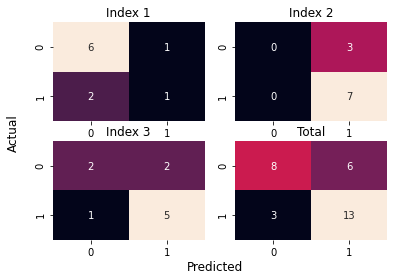

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error
from VanillaLSTM import VanillaLSTM
from StackedLSTM import StackedLSTM
from BidirectionalLSTM import BidirectionalLSTM
from ConvLSTM import ConvLSTM
from CnnLSTM import CnnLSTM

epochs = 30
batch_size = 16
n_steps = 3
n_outputs = 3
n_evaluations = 10
n_neurons = 30
n_seed = 0
optimizer = 'rmsprop'
loss = 'mean_absolute_error'

seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks_close, btc_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
139/139 [==============================] - 2s 5ms/step - loss: 0.0035 - accurac

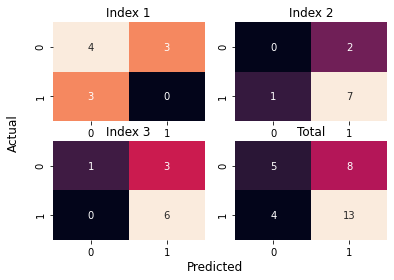

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks_close, eth_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
139/139 [==============================] - 2s 5ms/step - loss: 0.0035 - accurac

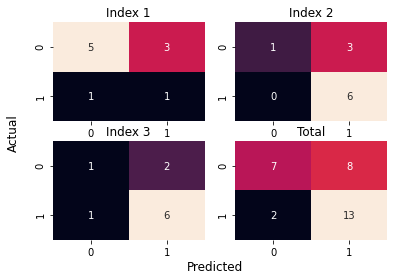

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks_close, ada_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
120/120 [==============================] - 2s 5ms/step - loss: 0.0025 - accurac

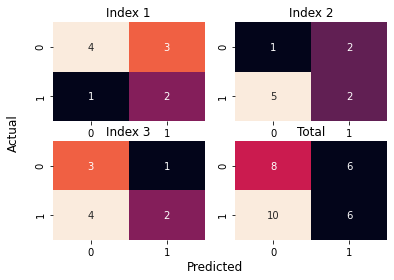

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks_close, btc_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
120/120 [==============================] - 2s 5ms/step - loss: 0.0025 - accurac

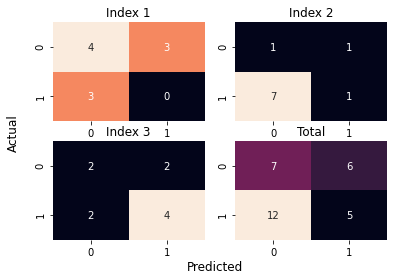

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks_close, eth_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
120/120 [==============================] - 2s 5ms/step - loss: 0.0025 - accurac

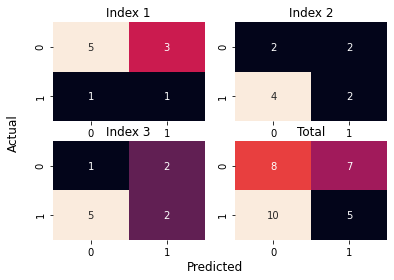

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks_close, ada_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
76/76 [==============================] - 2s 7ms/step - loss: 0.0036 - accuracy:

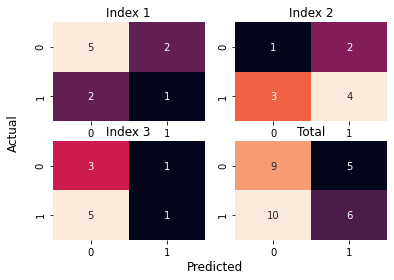

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks_close, btc_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
76/76 [==============================] - 2s 8ms/step - loss: 0.0036 - accuracy:

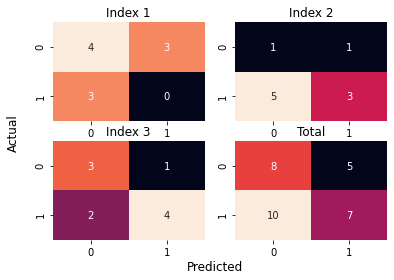

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks_close, eth_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 93        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
76/76 [==============================] - 2s 7ms/step - loss: 0.0036 - accuracy:

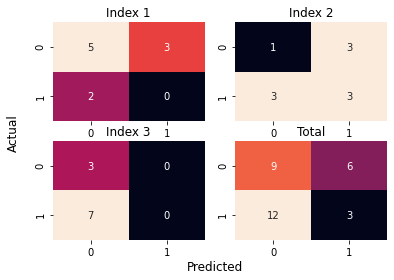

In [ ]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = CnnLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks_close, ada_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)